# Plotting and Visualization Code

In [222]:
from nilearn.plotting import plot_img_on_surf
from nilearn import surface, datasets, image
import nibabel as nib
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
import os, glob

In [223]:
# ─── adjust if you changed any names  ─────────────────────────────
stim_label = "reachforstars"
model_key   = "trait_9"                    # Choose model key (mental_8, personality_5, all_13, trait_9)

base = Path("/Volumes/Passport/fmriprep/derivatives")
perm_dir = base / "RSA_stats" / stim_label / "perm_test_neural_shift"

smoothing_setting     = "_no_smoothing"              # set smoothing to _no_smoothing or ""
template = datasets.load_mni152_template()    
out_dir     = perm_dir / "figs";  out_dir.mkdir(exist_ok=True)

p_img_path  = perm_dir / f"{stim_label}_perm_pmap_{model_key}_k1{smoothing_setting}.nii.gz"



In [224]:
# 1) load volume & fetch fsaverage5 (≈10 k vertices) ─────────────
p_img  = nib.load(p_img_path)
p_img_unthresholded  = nib.load(p_img_path)
fsavg  = datasets.fetch_surf_fsaverage(mesh="fsaverage5")

# helper ─ convert a volume → surface texture for both hems
def vol_to_surf_pair(img):
    tex_l = surface.vol_to_surf(img, fsavg.pial_left,  radius=3.)
    tex_r = surface.vol_to_surf(img, fsavg.pial_right, radius=3.)
    return tex_l, tex_r


In [225]:
# --- parameters -------------------------------------------------
thresh        = 0.05         # threshold for p-values
pmap_label           = f"{stim_label}_pmap_{model_key}_neural_shift_"   # label for title / filename

In [226]:
# --- load & resample Schaefer atlas to match p_img space ----------
schaefer   = datasets.fetch_atlas_schaefer_2018(
                 n_rois=200, yeo_networks=17,
                 resolution_mm=2
             )
atlas_img  = nib.load(schaefer["maps"])
atlas_res  = image.resample_to_img(
                 atlas_img, p_img, interpolation="nearest"
             )
atlas_data = atlas_res.get_fdata().astype(int)

# p-map brain plotting

In [227]:
import numpy as np
import matplotlib.pyplot as plt

def fix_colorbar_ticks(fig_or_tuple, lo, hi, n=6, fmt="{:.2f}"):
    """
    Force evenly spaced ticks on the colour-bar of a figure produced by
    plot_img_on_surf, regardless of nilearn version.

    Parameters
    ----------
    fig_or_tuple : Figure | (Figure, ...)
        Whatever plot_img_on_surf returned (figure alone or tuple).
    lo, hi       : float
        Lower and upper limits used for vmin / vmax.
    n            : int
        Number of ticks (default 6).
    fmt          : str
        Format string for tick labels (e.g., "{:.02f}").
    """
    # ----------------------------------------------------------
    # 1) get the Figure object
    # ----------------------------------------------------------
    if isinstance(fig_or_tuple, tuple):
        fig = fig_or_tuple[0]     # first item is always the Figure
    else:
        fig = fig_or_tuple

    # ----------------------------------------------------------
    # 2) colour-bar axis is always the last one added
    # ----------------------------------------------------------
    cbar_ax = fig.axes[-1]

    # ----------------------------------------------------------
    # 3) apply ticks / labels
    # ----------------------------------------------------------
    ticks = np.linspace(lo, hi, n)
    labels = [fmt.format(t) for t in ticks]

    if cbar_ax.xaxis.get_visible():          # horizontal colour-bar
        cbar_ax.set_xticks(ticks)
        cbar_ax.set_xticklabels(labels)
    else:                                    # vertical colour-bar
        cbar_ax.set_yticks(ticks)
        cbar_ax.set_yticklabels(labels)

In [228]:
# --- mask p-values ≥ .05 ---------------------------------------
p_data         = p_img.get_fdata()
p_data[p_data >= thresh] = np.nan           # keep only p < .05
thresholded    = nib.Nifti1Image(p_data, affine=p_img.affine,
                                 header=p_img.header)



# --- force atlas==0 voxels → nan in the 1-p map --------------------
p_data[atlas_data == 0] = np.nan


inv_img      = nib.Nifti1Image(p_data, affine=p_img.affine,
                               header=p_img.header)

corrected_nifti_path = out_dir / f"{stim_label}_{pmap_label}_threshold05.nii.gz"
nib.save(inv_img, corrected_nifti_path)
print("✅  Corrected 1–p NIfTI written →", corrected_nifti_path)

# --- plot on fsaverage surface ---------------------------------
fig = plot_img_on_surf(
    thresholded,
    surf_mesh='fsaverage',
    views=['lateral', 'medial'],
    hemispheres=['left', 'right'],
    title=f"{stim_label} {pmap_label} (p<{thresh}, k=1 {smoothing_setting})",
    colorbar=True,
    inflate=True,
    cmap='autumn',
    vmin=0.00,           # lower colour-bar bound
    vmax=0.05,   
    bg_on_data=True 
    )              
fix_colorbar_ticks(fig, lo = 0.00, hi = 0.05, n=2, fmt="{:.02f}")   

# --- save figure -----------------------------------------------
out_path = out_dir / f"{stim_label}_{pmap_label}_threshold05.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close('all')   

print("✅  Figure written →", out_path)

✅  Corrected 1–p NIfTI written → /Volumes/Passport/fmriprep/derivatives/RSA_stats/reachforstars/perm_test_neural_shift/figs/reachforstars_reachforstars_pmap_trait_9_neural_shift__threshold05.nii.gz


/opt/anaconda3/lib/python3.12/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/opt/anaconda3/lib/python3.12/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


✅  Figure written → /Volumes/Passport/fmriprep/derivatives/RSA_stats/reachforstars/perm_test_neural_shift/figs/reachforstars_reachforstars_pmap_trait_9_neural_shift__threshold05.png


# 1-p p-map brain plotting

In [229]:
# -----------------------------------------------------------------
# SECOND MAP  ▸  1-p “significance” map   (retain 1-p ≥ 0.95)
# -----------------------------------------------------------------
inv_thresh   = 1.0 - thresh          # 0.95
inv_label    = f"{stim_label}_inv_pmap_{model_key}_neural_shift_threshold05"

# --- compute 1-p & mask -----------------------------------------
inv_p_data   = 1.0 - p_img.get_fdata()
inv_p_data[inv_p_data < inv_thresh] = np.nan    # keep 1-p ≥ .95



# --- force atlas==0 voxels → nan in the 1-p map --------------------
inv_p_data[atlas_data == 0] = np.nan


inv_img      = nib.Nifti1Image(inv_p_data, affine=p_img.affine,
                               header=p_img.header)

corrected_nifti_path = out_dir / f"{inv_label}.nii.gz"
nib.save(inv_img, corrected_nifti_path)
print("✅  Corrected 1–p NIfTI written →", corrected_nifti_path)


# --- plot on surface --------------------------------------------
fig2 = plot_img_on_surf(
    inv_img,
    surf_mesh='fsaverage',
    views=['lateral', 'medial'],
    hemispheres=['left', 'right'],
    title=f"{stim_label} {inv_label} (1-p≥{inv_thresh}, k=1 {smoothing_setting})",
    colorbar=True,
    inflate=True,
    cmap='autumn',        # dark→bright as significance ↑
    vmin=inv_thresh,   # 0.95
    vmax=1.0,
    bg_on_data=True
)
fix_colorbar_ticks(fig2, lo = 0.95, hi = 1, n=2, fmt="{:.02f}")   
# --- save --------------------------------------------------------
out_path2 = out_dir / f"{inv_label}.png"
plt.savefig(out_path2, dpi=300, bbox_inches='tight')
plt.close('all')

print("✅  Figure written →", out_path2)

✅  Corrected 1–p NIfTI written → /Volumes/Passport/fmriprep/derivatives/RSA_stats/reachforstars/perm_test_neural_shift/figs/reachforstars_inv_pmap_trait_9_neural_shift_threshold05.nii.gz


/opt/anaconda3/lib/python3.12/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/opt/anaconda3/lib/python3.12/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


✅  Figure written → /Volumes/Passport/fmriprep/derivatives/RSA_stats/reachforstars/perm_test_neural_shift/figs/reachforstars_inv_pmap_trait_9_neural_shift_threshold05.png


In [230]:
# -----------------------------------------------------------------
# SECOND MAP  ▸  1-p “significance” map   (retain 1-p ≥ 0.95)
# -----------------------------------------------------------------
inv_unthresholded_label    = f"{stim_label}_inv_pmap_{model_key}_neural_shift_unthresholded"


# --- get raw p-values and FIX zeros ---------------------------
p_dat = p_img_unthresholded.get_fdata()
p_dat[p_dat == 0] = 1.0           # ← treat background/empty voxels as p = 1

# --- compute 1-p & mask -----------------------------------------
inv_p_data   = 1.0 - p_dat

# --- force atlas==0 voxels → nan in the 1-p map --------------------
inv_p_data[atlas_data == 0] = np.nan


inv_img      = nib.Nifti1Image(inv_p_data, affine=p_img_unthresholded.affine,
                               header=p_img_unthresholded.header)

corrected_nifti_path = out_dir / f"{inv_unthresholded_label}.nii.gz"
nib.save(inv_img, corrected_nifti_path)
print("✅  Corrected 1–p NIfTI written →", corrected_nifti_path)


# --- plot on surface --------------------------------------------
fig2 = plot_img_on_surf(
    inv_img,
    surf_mesh='fsaverage5',
    views=['lateral', 'medial'],
    hemispheres=['left', 'right'],
    title=f"{stim_label} {inv_unthresholded_label} (1-p, k=1 {smoothing_setting})",
    colorbar=True,
    inflate=True,
    cmap='autumn',        # dark→bright as significance ↑
    vmin= 0,   
    vmax=1.0,
    threshold=None,
    bg_on_data=True
)
fix_colorbar_ticks(fig2, lo = 0, hi = 1, n=2, fmt="{:.02f}")   
# --- save --------------------------------------------------------
out_path2 = out_dir / f"{inv_unthresholded_label}.png"
plt.savefig(out_path2, dpi=300, bbox_inches='tight')
plt.close('all')

print("✅  Figure written →", out_path2)

✅  Corrected 1–p NIfTI written → /Volumes/Passport/fmriprep/derivatives/RSA_stats/reachforstars/perm_test_neural_shift/figs/reachforstars_inv_pmap_trait_9_neural_shift_unthresholded.nii.gz


/opt/anaconda3/lib/python3.12/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/opt/anaconda3/lib/python3.12/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


✅  Figure written → /Volumes/Passport/fmriprep/derivatives/RSA_stats/reachforstars/perm_test_neural_shift/figs/reachforstars_inv_pmap_trait_9_neural_shift_unthresholded.png


# Trait RDM Plotting

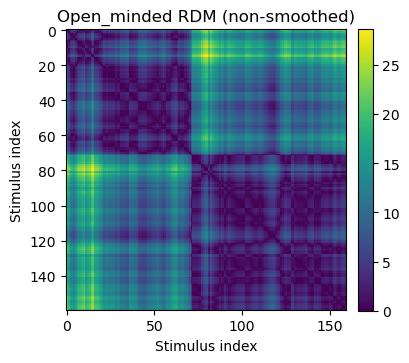

✅  Figure   Open_minded_RDM.png written


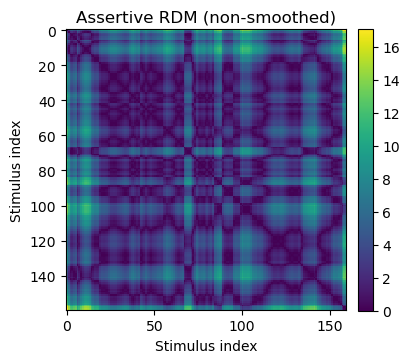

✅  Figure   Assertive_RDM.png written


In [231]:
behav_dir = Path("/Volumes/Passport/fmriprep/derivatives/RDMs_behavior")

def plot_dm(trait):
    fname = behav_dir / f"{stim_label}_{trait.replace(' ', '_')}_RDM{smoothing_setting}.npy"
    dm    = np.load(fname)

    plt.figure(figsize=(4.2, 4))
    im = plt.imshow(dm, cmap="viridis", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f"{trait} RDM (non-smoothed)")
    plt.xlabel("Stimulus index"); plt.ylabel("Stimulus index")

    out = out_dir / f"{trait.replace(' ', '_')}_RDM.png"
    plt.tight_layout();  plt.savefig(out, dpi=300);  plt.show()
    print("✅  Figure  ", out.name, "written")

for t in ["Open_minded", "Assertive"]:
    plot_dm(t)

# Neural RDM Plotting

In [232]:
sub = "sub-002"
run = "1"
deriv_dir = "/Volumes/Passport/fmriprep/derivatives"
     

# find the exact bold file for run-001:
bold_pattern = os.path.join(
    deriv_dir, f"{stim_label}__cleaned", sub, "func",
    f"{sub}_task-{stim_label}__run-{run}_*cleaned_desc-masked_bold.nii.gz"
)
bf = glob.glob(bold_pattern)[0]
bold_img = nib.load(bf)
bold_data = bold_img.get_fdata()
atlas_res = resample_to_img(atlas_img, bold_img, interpolation="nearest")
atlas_dat = atlas_res.get_fdata()

# choose a parcel (e.g. parcel_id = 1)
parcel_id = 1
mask = atlas_dat == parcel_id

neural_rdm = 1 - np.corrcoef(bold_data[mask, :].T).astype(np.float32)

# save to disk:
neural_dir = os.path.join(deriv_dir, "RDMs_neural")
os.makedirs(neural_dir, exist_ok=True)
outfile = os.path.join(
    neural_dir,
    f"{sub}_run-{run}_parcel-{parcel_id}_RDM.npy"
)
np.save(outfile, neural_rdm)
print("Saved neural RDM →", outfile)

IndexError: list index out of range

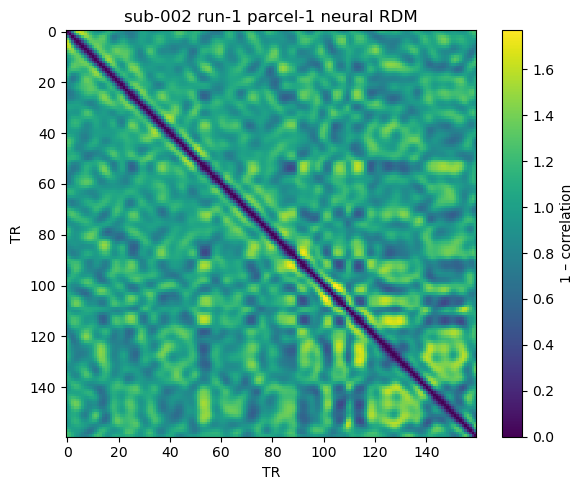

In [ ]:

# 1) Specify the same file you saved earlier
sub = "sub-002"
run = "1"
parcel_id = 1
deriv_dir = "/Volumes/Passport/fmriprep/derivatives"


outfile = os.path.join(
    deriv_dir,
    "RDMs_neural",
    f"{sub}_run-{run}_parcel-{parcel_id}_RDM.npy"
)

# 2) Load the saved neural RDM
neural_rdm = np.load(outfile)

# 3) Plot it
plt.figure(figsize=(6, 5))
plt.imshow(neural_rdm, interpolation="nearest", aspect="auto")
plt.title(f"{sub} run-{run} parcel-{parcel_id} neural RDM")
plt.xlabel("TR")
plt.ylabel("TR")
cbar = plt.colorbar()
cbar.set_label("1 – correlation")
plt.tight_layout()
plt.show()